UCI-HAR Comprehensive Experiments
Loading UCI HAR data from: /content/
  Loaded body_acc_x: train=(7352, 128), test=(2947, 128)
  Loaded body_acc_y: train=(7352, 128), test=(2947, 128)
  Loaded body_acc_z: train=(7352, 128), test=(2947, 128)
  Loaded body_gyro_x: train=(7352, 128), test=(2947, 128)
  Loaded body_gyro_y: train=(7352, 128), test=(2947, 128)
  Loaded body_gyro_z: train=(7352, 128), test=(2947, 128)
  Loaded total_acc_x: train=(7352, 128), test=(2947, 128)
  Loaded total_acc_y: train=(7352, 128), test=(2947, 128)
  Loaded total_acc_z: train=(7352, 128), test=(2947, 128)
Stacked signals - train: (7352, 128, 9), test: (2947, 128, 9)
Transposed X shape - train: (7352, 9, 128), test: (2947, 9, 128)
Loaded labels - train: (7352,), test: (2947,)
Train labels: [0 1 2 3 4 5]
Test labels: [0 1 2 3 4 5]
Using device: cuda
Model FLOPs: 10.95 MMac
Model Params: 1.23 M
Starting training...
[Epoch 01] train_loss=1.2612 (act=0.9000, rot=0.4693, orbit=1.0285, rc=0.0737) train_acc=0.7074
 

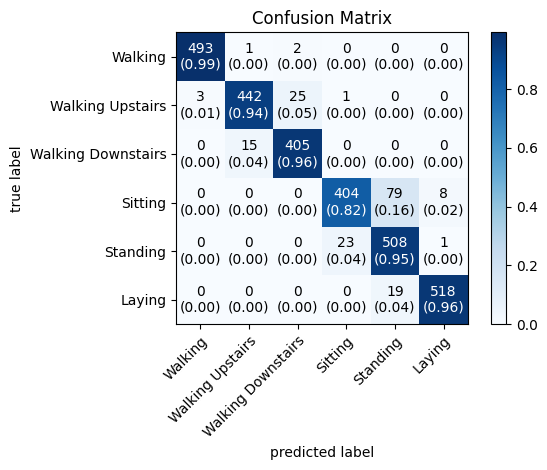

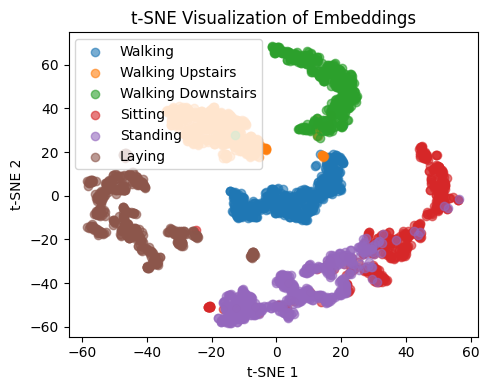


Evaluation complete!

##############################
ROCO_TTA
##############################
Final evaluation...

=== FINAL RESULTS ===
Accuracy: 0.9281
F1 Score: 0.9288
Precision: 0.9342
Recall: 0.9281
Sensitivity: 0.9281
Silhouette Score: 0.5380
Training Time: 1415.96s
Inference Time: 34.54s

Class-wise F1 Scores:
Walking: 0.9910
Walking Upstairs: 0.9483
Walking Downstairs: 0.9484
Sitting: 0.8498
Standing: 0.8702
Laying: 0.9650

Generating visualizations...


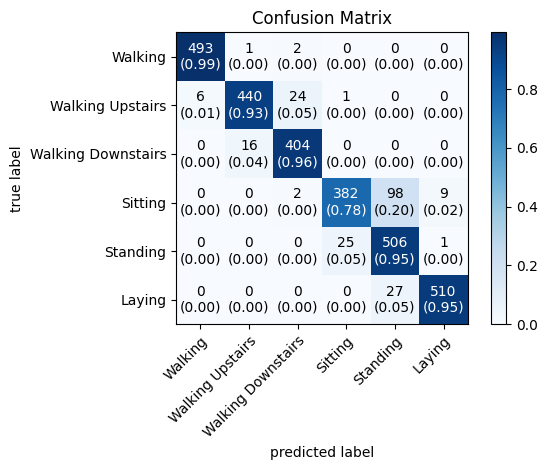

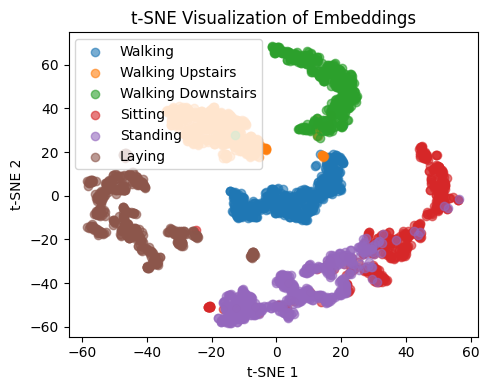


Evaluation complete!



In [8]:
import os
import io
import math
import zipfile
import urllib.request
import time
from pathlib import Path
from typing import Tuple

import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, silhouette_score, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.plotting import plot_confusion_matrix
from ptflops import get_model_complexity_info

def load_uci_har_raw(dataset_path):
    print(f"Loading UCI HAR data from: {dataset_path}")
    SIGNALS = ["body_acc_x", "body_acc_y", "body_acc_z",
               "body_gyro_x", "body_gyro_y", "body_gyro_z",
               "total_acc_x", "total_acc_y", "total_acc_z"]

    X_train_list = []
    X_test_list = []

    for signal in SIGNALS:
        train_file = os.path.join(dataset_path, f"{signal}_train.txt")
        test_file = os.path.join(dataset_path, f"{signal}_test.txt")
        try:
            train_signal = np.loadtxt(train_file, dtype=np.float32)
            test_signal = np.loadtxt(test_file, dtype=np.float32)
            X_train_list.append(train_signal)
            X_test_list.append(test_signal)
            print(f"  Loaded {signal}: train={train_signal.shape}, test={test_signal.shape}")
        except FileNotFoundError as e:
            print(f"Error loading file: {e}. Check dataset_path.")
            return None, None, None, None, None
        except Exception as e:
            print(f"An error occurred loading {signal}: {e}")
            return None, None, None, None, None

    if not X_train_list:
        print("No signal data loaded.")
        return None, None, None, None, None

    X_train = np.stack(X_train_list, axis=-1)
    X_test = np.stack(X_test_list, axis=-1)
    print(f"Stacked signals - train: {X_train.shape}, test: {X_test.shape}")

    X_train = np.transpose(X_train, (0, 2, 1))
    X_test = np.transpose(X_test, (0, 2, 1))
    print(f"Transposed X shape - train: {X_train.shape}, test: {X_test.shape}")

    try:
        y_train = np.loadtxt(os.path.join(dataset_path, "y_train.txt"), dtype=int) - 1
        y_test = np.loadtxt(os.path.join(dataset_path, "y_test.txt"), dtype=int) - 1
        print(f"Loaded labels - train: {y_train.shape}, test: {y_test.shape}")
        print(f"Train labels: {np.unique(y_train)}")
        print(f"Test labels: {np.unique(y_test)}")
    except FileNotFoundError as e:
        print(f"Error loading label file: {e}. Check dataset_path.")
        return None, None, None, None, None
    except Exception as e:
        print(f"An error occurred loading labels: {e}")
        return None, None, None, None, None

    ucihar_activity_names = ['Walking', 'Walking Upstairs', 'Walking Downstairs', 'Sitting', 'Standing', 'Laying']

    return X_train, y_train, X_test, y_test, ucihar_activity_names

def _batched_rotation_matrix(angles):
    B = angles.shape[0]
    rx, ry, rz = angles[:, 0], angles[:, 1], angles[:, 2]

    cx, sx = torch.cos(rx), torch.sin(rx)
    cy, sy = torch.cos(ry), torch.sin(ry)
    cz, sz = torch.cos(rz), torch.sin(rz)

    Rx = torch.zeros(B, 3, 3, device=angles.device, dtype=angles.dtype)
    Rx[:, 0, 0] = 1.
    Rx[:, 1, 1] = cx; Rx[:, 1, 2] = -sx
    Rx[:, 2, 1] = sx; Rx[:, 2, 2] = cx

    Ry = torch.zeros(B, 3, 3, device=angles.device, dtype=angles.dtype)
    Ry[:, 0, 0] = cy;  Ry[:, 0, 2] = sy
    Ry[:, 1, 1] = 1.
    Ry[:, 2, 0] = -sy; Ry[:, 2, 2] = cy

    Rz = torch.zeros(B, 3, 3, device=angles.device, dtype=angles.dtype)
    Rz[:, 0, 0] = cz; Rz[:, 0, 1] = -sz
    Rz[:, 1, 0] = sz; Rz[:, 1, 1] = cz
    Rz[:, 2, 2] = 1.

    R = Rz @ Ry @ Rx
    return R

def apply_random_rotation_xyz(x, max_deg=20.0, group_size=3):
    B, T, C = x.shape
    assert C % group_size == 0
    G = C // group_size

    max_rad = max_deg * math.pi / 180.0
    angles = (torch.rand(B, 3, device=x.device, dtype=x.dtype) * 2 - 1) * max_rad
    R = _batched_rotation_matrix(angles)

    x_rot = x.clone()
    for g in range(G):
        seg = x[:, :, g*group_size:(g+1)*group_size]
        seg2 = seg.reshape(B*T, 3)
        Rb = R.repeat_interleave(T, dim=0)
        seg_rot = (Rb @ seg2.unsqueeze(-1)).squeeze(-1)
        x_rot[:, :, g*group_size:(g+1)*group_size] = seg_rot.view(B, T, 3)
    return x_rot

def make_rotation_class(x, num_rotations=4):
    device = x.device
    B, T, C = x.shape
    angles_deg = torch.tensor([0., 90., 180., 270.], device=device, dtype=x.dtype)
    labels = torch.randint(0, len(angles_deg), (B,), device=device, dtype=torch.long)
    rad = angles_deg[labels] * math.pi / 180.0

    angles = torch.stack([torch.zeros_like(rad), torch.zeros_like(rad), rad], dim=1)
    R = _batched_rotation_matrix(angles)

    x_rot = x.clone()
    G = C // 3
    for g in range(G):
        seg = x[:, :, g*3:(g+1)*3]
        seg2 = seg.reshape(B*T, 3)
        Rb = R.repeat_interleave(T, dim=0)
        seg_rot = (Rb @ seg2.unsqueeze(-1)).squeeze(-1)
        x_rot[:, :, g*3:(g+1)*3] = seg_rot.view(B, T, 3)

    return x_rot, labels


class DSConv1D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, use_residual=True):
        super().__init__()
        self.depthwise = nn.Conv1d(in_channels, in_channels, kernel_size=kernel_size,
                                   padding=kernel_size // 2, groups=in_channels, bias=False)
        self.pointwise = nn.Conv1d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn = nn.BatchNorm1d(out_channels)
        self.act = nn.LeakyReLU(negative_slope=0.1, inplace=True)

        self.use_residual = use_residual and (in_channels == out_channels)
        if use_residual and in_channels != out_channels:
            self.residual_proj = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1, bias=False),
                nn.BatchNorm1d(out_channels)
            )
        else:
            self.residual_proj = None

    def forward(self, x):
        identity = x
        out = self.depthwise(x)
        out = self.pointwise(out)
        out = self.bn(out)

        if self.use_residual:
            if self.residual_proj is not None:
                identity = self.residual_proj(identity)
            out = out + identity

        out = self.act(out)
        return out

class InceptionBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.branch1 = nn.Sequential(
            nn.MaxPool1d(kernel_size=3, stride=1, padding=1),
            DSConv1D(in_channels, out_channels, kernel_size=1, use_residual=False)
        )
        self.branch2 = DSConv1D(in_channels, out_channels, kernel_size=1, use_residual=False)
        self.branch3 = DSConv1D(in_channels, out_channels, kernel_size=3, use_residual=False)
        self.branch4 = DSConv1D(in_channels, out_channels, kernel_size=5, use_residual=False)

        total_out_channels = out_channels * 4
        if in_channels != total_out_channels:
            self.residual_proj = nn.Sequential(
                nn.Conv1d(in_channels, total_out_channels, kernel_size=1, bias=False),
                nn.BatchNorm1d(total_out_channels)
            )
        else:
            self.residual_proj = None

        self.relu = nn.LeakyReLU(negative_slope=0.1, inplace=True)

    def forward(self, x):
        identity = x
        out = torch.cat([
            self.branch1(x), self.branch2(x),
            self.branch3(x), self.branch4(x)
        ], dim=1)

        if self.residual_proj is not None:
            identity = self.residual_proj(identity)
        out = out + identity

        return self.relu(out)

class MultiKernelBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.branch1 = DSConv1D(in_channels, out_channels, kernel_size=1, use_residual=False)
        self.branch2 = DSConv1D(in_channels, out_channels, kernel_size=3, use_residual=False)
        self.branch3 = DSConv1D(in_channels, out_channels, kernel_size=5, use_residual=False)
        self.branch4 = DSConv1D(in_channels, out_channels, kernel_size=7, use_residual=False)

        total_out_channels = out_channels * 4
        if in_channels != total_out_channels:
            self.residual_proj = nn.Sequential(
                nn.Conv1d(in_channels, total_out_channels, kernel_size=1, bias=False),
                nn.BatchNorm1d(total_out_channels)
            )
        else:
            self.residual_proj = None

        self.relu = nn.LeakyReLU(negative_slope=0.1, inplace=True)

    def forward(self, x):
        identity = x
        out = torch.cat([
            self.branch1(x), self.branch2(x),
            self.branch3(x), self.branch4(x)
        ], dim=1)

        if self.residual_proj is not None:
            identity = self.residual_proj(identity)
        out = out + identity

        return self.relu(out)

class FeatureAdapter(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.gamma = nn.Parameter(torch.ones(1, dim))
        self.beta = nn.Parameter(torch.zeros(1, dim))

    def forward(self, z):
        return z * self.gamma + self.beta

class InceptionMK(nn.Module):
    def __init__(self, input_channels=9, stem_out=128, block_out=64,
                 embedding_dim=256, num_classes=6, num_rotations=4):
        super().__init__()

        self.stem = nn.Sequential(
            nn.Conv1d(input_channels, stem_out, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm1d(stem_out),
            nn.LeakyReLU(negative_slope=0.1, inplace=True)
        )

        self.stem_residual = DSConv1D(stem_out, stem_out, kernel_size=3, use_residual=True)
        self.inception = InceptionBlock(stem_out, block_out)
        self.mk_block = MultiKernelBlock(block_out * 4, block_out)

        mk_out_channels = block_out * 4
        self.inter_residual = DSConv1D(mk_out_channels, mk_out_channels, kernel_size=3, use_residual=True)

        self.time_reduce = nn.Sequential(
            nn.Conv1d(mk_out_channels, mk_out_channels, kernel_size=4, stride=4, padding=0),
            nn.BatchNorm1d(mk_out_channels),
            nn.LeakyReLU(negative_slope=0.1, inplace=True)
        )

        flattened_size = mk_out_channels * 32
        self.fc = nn.Sequential(
            nn.Linear(flattened_size, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout(0.1),
            nn.Linear(256, embedding_dim)
        )


        self.adapter = FeatureAdapter(embedding_dim)

        self.head_act = nn.Sequential(
            nn.LayerNorm(embedding_dim),
            nn.Linear(embedding_dim, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(negative_slope=0.1, inplace=True),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(negative_slope=0.1, inplace=True),
            nn.Dropout(0.1),
            nn.Linear(32, num_classes)
        )

        self.head_rot = nn.Sequential(
            nn.LayerNorm(embedding_dim),
            nn.Linear(embedding_dim, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(negative_slope=0.1, inplace=True),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(negative_slope=0.1, inplace=True),
            nn.Dropout(0.1),
            nn.Linear(32, num_rotations)
        )

        self.num_classes = num_classes
        self.embedding_dim = embedding_dim
        self.register_buffer("prototypes", torch.zeros(num_classes, embedding_dim))
        self.register_buffer("proto_counts", torch.zeros(num_classes))
        self.proto_m = 0.99

    def forward(self, x):
        x = x.transpose(1, 2)

        x = self.stem(x)
        x = self.stem_residual(x)
        x = self.inception(x)
        x = self.mk_block(x)
        x = self.inter_residual(x)

        x = self.time_reduce(x)
        x = x.flatten(1)
        z = self.fc(x)
        z = self.adapter(z)

        logits_act = self.head_act(z)
        logits_rot = self.head_rot(z)

        return logits_act, logits_rot, z

    @torch.no_grad()
    def update_prototypes(self, z, y):
        if z.size(0) == 0:
            return

        z_n = F.normalize(z, dim=-1)
        unique_classes = y.unique()

        for c in unique_classes:
            mask = (y == c)
            if mask.any():
                z_class = z_n[mask].mean(dim=0)
                count = self.proto_counts[c]

                if count == 0:
                    self.prototypes[c] = z_class
                    self.proto_counts[c] = 1
                else:
                    self.prototypes[c] = self.proto_m * self.prototypes[c] + (1 - self.proto_m) * z_class
                    self.proto_counts[c] += 1

def rotation_consistency_loss(model, x, K=2, max_deg=15.0, temperature=1.0):
    with torch.no_grad():
        base_logits, _, _ = model.forward(x)
        base_logits = base_logits / temperature
        p_base = F.softmax(base_logits, dim=-1)

    kl_losses = []
    for _ in range(K):
        xr = apply_random_rotation_xyz(x, max_deg=max_deg)
        logits_r, _, _ = model.forward(xr)
        p_r = F.log_softmax(logits_r / temperature, dim=-1)
        kl = F.kl_div(p_r, p_base, reduction='batchmean', log_target=False)
        kl_losses.append(kl)

    return sum(kl_losses) / len(kl_losses)

def proto_orbit_loss(model, x, y, K=2, max_deg=20.0, temperature=0.2):
    proto = model.prototypes.detach()
    proto_n = F.normalize(proto, dim=-1)

    if torch.all(proto == 0):
        dummy_loss = torch.zeros(1, device=x.device, requires_grad=True)
        return dummy_loss.sum()

    losses = []
    for _ in range(K):
        xr = apply_random_rotation_xyz(x, max_deg=max_deg)
        _, _, z_r = model(xr)
        z_r = F.normalize(z_r, dim=-1)
        logits = (z_r @ proto_n.t()) / temperature
        loss = F.cross_entropy(logits, y)
        losses.append(loss)

    return sum(losses) / len(losses)

def _entropy(p):
    return -(p * (p.clamp_min(1e-8).log())).sum(dim=-1)

def roco_tta_predict(model, x, steps=10, K=6, lr=2e-3, max_deg=40.0, temperature=0.2, weight_cons=2.0):
    was_training = model.training
    model.eval()

    original_state = {}
    for name, param in model.named_parameters():
        original_state[name] = param.data.clone()

    bn_backup = {}
    for name, module in model.named_modules():
        if isinstance(module, nn.BatchNorm1d):
            bn_backup[name] = {
                'running_mean': module.running_mean.clone(),
                'running_var': module.running_var.clone(),
                'num_batches_tracked': module.num_batches_tracked.clone() if module.num_batches_tracked is not None else None
            }
    for name, param in model.named_parameters():
        param.requires_grad_(False)

    tta_params = []
    for param in model.adapter.parameters():
        param.requires_grad_(True)
        tta_params.append(param)

    for name, module in model.named_modules():
        if isinstance(module, nn.BatchNorm1d):
            module.eval()
            if module.affine:
                module.weight.requires_grad_(True)
                module.bias.requires_grad_(True)
                tta_params.append(module.weight)
                tta_params.append(module.bias)

    if not tta_params:
        return model(x)[0].softmax(dim=-1)

    opt = torch.optim.AdamW(tta_params, lr=lr, weight_decay=1e-5)

    # TTA optimization
    for step in range(steps):
        opt.zero_grad()

        lo0, _, _ = model.forward(x)
        p0 = F.softmax(lo0 / temperature, dim=-1)
        ent = _entropy(p0).mean()

        kl = 0.0
        for _k in range(K):
            xr = apply_random_rotation_xyz(x, max_deg=max_deg)
            lor, _, _ = model.forward(xr)
            pr = F.log_softmax(lor / temperature, dim=-1)
            kl += F.kl_div(pr, p0.detach(), reduction='batchmean', log_target=False)
        kl = kl / K

        loss = ent + weight_cons * kl
        loss.backward()
        torch.nn.utils.clip_grad_norm_(tta_params, max_norm=1.0)
        opt.step()


    probs = []
    with torch.no_grad():
        for _k in range(K * 2):
            xr = apply_random_rotation_xyz(x, max_deg=max_deg * 0.5)
            lor, _, _ = model.forward(xr)
            probs.append(F.softmax(lor, dim=-1))
    probs = torch.stack(probs, dim=0).mean(dim=0)

    with torch.no_grad():
        for name, param in model.named_parameters():
            param.data.copy_(original_state[name])

    for name, module in model.named_modules():
        if isinstance(module, nn.BatchNorm1d) and name in bn_backup:
            module.running_mean.copy_(bn_backup[name]['running_mean'])
            module.running_var.copy_(bn_backup[name]['running_var'])
            if module.num_batches_tracked is not None:
                module.num_batches_tracked.copy_(bn_backup[name]['num_batches_tracked'])

    for param in model.parameters():
        param.requires_grad_(True)

    if was_training:
        model.train()
    else:
        model.eval()

    return probs

class UCIHARInertial(Dataset):
    def __init__(self, X, y, scaler: StandardScaler=None, train: bool=True,
                 rot_ssl: bool=True, num_rotations: int=4, p_rotate_ssl: float=0.5):
        self.X = X.astype(np.float32)
        self.y = y.astype(np.int64)
        self.train = train
        self.rot_ssl = rot_ssl
        self.num_rot = num_rotations
        self.p_rotate_ssl = p_rotate_ssl

        self.scaler = scaler
        if self.scaler is not None:
            N, C, T = self.X.shape
            X2 = self.X.reshape(-1, C)
            X2 = self.scaler.transform(X2)
            self.X = X2.reshape(N, C, T)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        x = torch.from_numpy(self.X[idx]).transpose(0, 1)
        y = torch.tensor(self.y[idx], dtype=torch.long)

        rot_label = torch.tensor(0, dtype=torch.long)
        x_ssl = x.clone()
        apply_rot = False

        if self.train and self.rot_ssl and np.random.rand() < self.p_rotate_ssl:
            apply_rot = True
            x_ssl_batch, rot_label_batch = make_rotation_class(x.unsqueeze(0), num_rotations=self.num_rot)
            x_ssl = x_ssl_batch.squeeze(0)
            rot_label = rot_label_batch.squeeze(0) if rot_label_batch.dim() > 0 else rot_label_batch

        return x_ssl, y, rot_label, torch.tensor(apply_rot, dtype=torch.bool)

def train_one_epoch(model, loader, optimizer, device,
                    lambda_rot=0.5, lambda_rc=0.1,
                    lambda_orbit=0.3, orbit_K=2, orbit_tau=0.2, orbit_max_deg=20.0):
    model.train()
    total_loss = total_act = total_rot = total_orbit = total_rc = 0.0
    correct = total = 0

    for batch_idx, (xb, yb, rb, msk) in enumerate(loader):
        try:
            xb, yb, rb, msk = xb.to(device), yb.to(device), rb.to(device), msk.to(device)

            lo_act, lo_rot, z = model(xb)
            loss_act = F.cross_entropy(lo_act, yb)

            if msk.any():
                loss_rot = F.cross_entropy(lo_rot[msk], rb[msk])
            else:
                loss_rot = torch.zeros_like(loss_act)

            with torch.no_grad():
                model.update_prototypes(z, yb)

            if lambda_orbit > 0.0 and model.proto_counts.sum() > 0:
                loss_orbit = proto_orbit_loss(model, xb, yb, K=orbit_K,
                                            max_deg=orbit_max_deg, temperature=orbit_tau)
            else:
                loss_orbit = torch.zeros_like(loss_act)

            loss_rc_val = torch.zeros_like(loss_act)
            if lambda_rc > 0:
                loss_rc_val = rotation_consistency_loss(model, xb, K=2, max_deg=15.0)

            loss = loss_act + lambda_rot * loss_rot + lambda_orbit * loss_orbit + lambda_rc * loss_rc_val

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            bs = xb.size(0)
            total += bs
            correct += (lo_act.argmax(dim=1) == yb).sum().item()
            total_loss += float(loss.item()) * bs
            total_act += float(loss_act.item()) * bs
            total_rot += float(loss_rot.item()) * bs
            total_orbit += float(loss_orbit.item()) * bs
            total_rc += float(loss_rc_val.item()) * bs

        except Exception as e:
            print(f"Error in batch {batch_idx}: {e}")
            continue

    acc = correct / total
    return (total_loss/total, total_act/total, total_rot/total,
            total_orbit/total, total_rc/total, acc)

@torch.no_grad()
def evaluate(model, loader, device, lambda_rot=0.5, lambda_orbit=0.3, lambda_rc=0.1, use_tta=False,
             tta_steps=10, tta_K=6, tta_lr=2e-3, tta_max_deg=40.0, tta_temperature=0.2, tta_weight_cons=2.0):
    model.eval()
    y_true, y_pred, embeddings = [], [], []
    correct = total = 0
    val_total_loss = val_act = val_rot = val_orbit = val_rc = 0.0

    for xb, yb, rb, msk in loader:
        xb, yb, rb, msk = xb.to(device), yb.to(device), rb.to(device), msk.to(device)
        y_true.append(yb.cpu().numpy())
        total += xb.size(0)

        if use_tta:
            with torch.enable_grad():
                probs = roco_tta_predict(model, xb, steps=tta_steps, K=tta_K, lr=tta_lr,
                                       max_deg=tta_max_deg, temperature=tta_temperature, weight_cons=tta_weight_cons)
            pred = probs.argmax(dim=-1).cpu().numpy()
            lo, lo_rot_val, z = model(xb)
            embeddings.append(z.cpu().numpy())
        else:
            lo, lo_rot_val, z = model(xb)
            pred = lo.argmax(dim=-1).cpu().numpy()
            embeddings.append(z.cpu().numpy())

        loss_act = F.cross_entropy(lo, yb)
        if msk.any():
            loss_rot = F.cross_entropy(lo_rot_val[msk], rb[msk])
        else:
            loss_rot = torch.zeros_like(loss_act)

        if lambda_orbit > 0.0 and model.proto_counts.sum() > 0:
            loss_orbit = proto_orbit_loss(model, xb, yb, K=2, max_deg=20.0, temperature=0.2)
        else:
            loss_orbit = torch.zeros_like(loss_act)

        loss_rc_val = torch.zeros_like(loss_act)
        if lambda_rc > 0:
            loss_rc_val = rotation_consistency_loss(model, xb, K=2, max_deg=15.0)

        bs = xb.size(0)
        val_act += float(loss_act.item()) * bs
        val_rot += float(loss_rot.item()) * bs
        val_orbit += float(loss_orbit.item()) * bs
        val_rc += float(loss_rc_val.item()) * bs
        val_total_loss += float((loss_act + lambda_rot * loss_rot + lambda_orbit * loss_orbit + lambda_rc * loss_rc_val).item()) * bs

        y_pred.append(pred)
        correct += (torch.from_numpy(pred) == yb.cpu()).sum().item()

    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    embeddings = np.concatenate(embeddings)

    acc = correct / total
    f1 = f1_score(y_true, y_pred, average="macro")
    precision = precision_score(y_true, y_pred, average="macro")
    recall = recall_score(y_true, y_pred, average="macro")

    return (acc, f1, precision, recall, y_true, y_pred, embeddings,
            val_total_loss/total, val_act/total, val_rot/total, val_orbit/total, val_rc/total)

def plot_confusion_matrix_mlxtend(y_true, y_pred, class_names):
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_true, y_pred)

    fig, ax = plot_confusion_matrix(conf_mat=cm,
                                    class_names=class_names,
                                    show_absolute=True,
                                    show_normed=True,
                                    colorbar=True)
    plt.title('Confusion Matrix')
    plt.tight_layout()
    return fig

def plot_tsne(embeddings, y_true, class_names):
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    embeddings_2d = tsne.fit_transform(embeddings)

    plt.figure(figsize=(5, 4))
    for i, class_name in enumerate(class_names):
        mask = y_true == i
        plt.scatter(embeddings_2d[mask, 0], embeddings_2d[mask, 1],
                   label=class_name, alpha=0.6)
    plt.legend()
    plt.title('t-SNE Visualization of Embeddings')
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.tight_layout()
    return plt.gcf()

def main():
    print("UCI-HAR Comprehensive Experiments")
    print("="*60)

    dataset_path = "/content/"
    X_train, y_train, X_test, y_test, class_names = load_uci_har_raw(dataset_path)

    if X_train is None:
        print("Failed to load data")
        return

    scaler = StandardScaler()
    N_train, C, T = X_train.shape
    X_train_reshaped = X_train.reshape(-1, C)
    scaler.fit(X_train_reshaped)

    X_train_scaled = scaler.transform(X_train_reshaped).reshape(N_train, C, T)
    N_test = X_test.shape[0]
    X_test_reshaped = X_test.reshape(-1, C)
    X_test_scaled = scaler.transform(X_test_reshaped).reshape(N_test, C, T)
    num_classes = len(set(y_train))

    train_ds = UCIHARInertial(X_train_scaled, y_train, train=True,
                              rot_ssl=True, num_rotations=4, p_rotate_ssl=0.7)
    test_ds = UCIHARInertial(X_test_scaled, y_test, train=False,
                             rot_ssl=False, num_rotations=4, p_rotate_ssl=0.0)

    train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=0, drop_last=False)
    test_loader = DataLoader(test_ds, batch_size=128, shuffle=False, num_workers=0, drop_last=False)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    model = InceptionMK(input_channels=9, stem_out=64, block_out=32,
                        embedding_dim=128, num_classes=num_classes, num_rotations=4).to(device)

    try:
        flops, params = get_model_complexity_info(model, (128, 9), as_strings=True, print_per_layer_stat=False)
        print(f"Model FLOPs: {flops}")
        print(f"Model Params: {params}")
    except:
        print("Could not compute model complexity")

    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-3)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100, eta_min=1e-5)

    best = {"acc": 0.0, "f1": 0.0, "state": None}
    epochs = 200
    patience = 50
    patience_counter = 0

    lambda_rot, lambda_orbit, lambda_rc = 0.3, 0.2, 0.2

    history = {
        'train_total_loss': [], 'train_act_loss': [], 'train_rot_loss': [],
        'train_orbit_loss': [], 'train_rc_loss': [], 'train_acc': [],
        'val_total_loss': [], 'val_act_loss': [], 'val_rot_loss': [],
        'val_orbit_loss': [], 'val_rc_loss': [], 'val_acc': [], 'val_f1': []
    }

    print("Starting training...")
    start_time = time.time()

    for ep in range(1, epochs+1):
        tr_total_loss, tr_act, tr_rot, tr_orb, tr_rc, tr_acc = train_one_epoch(
            model, train_loader, optimizer, device,
            lambda_rot=lambda_rot, lambda_rc=lambda_rc, lambda_orbit=lambda_orbit,
            orbit_K=2, orbit_tau=0.3, orbit_max_deg=15.0
        )

        results = evaluate(model, test_loader, device, lambda_rot, lambda_orbit, lambda_rc, use_tta=False)
        acc, f1, precision, recall, y_true, y_pred, embeddings, val_total_loss, val_act, val_rot, val_orbit, val_rc = results

        scheduler.step()

        history['train_total_loss'].append(tr_total_loss)
        history['train_act_loss'].append(tr_act)
        history['train_rot_loss'].append(tr_rot)
        history['train_orbit_loss'].append(tr_orb)
        history['train_rc_loss'].append(tr_rc)
        history['train_acc'].append(tr_acc)
        history['val_total_loss'].append(val_total_loss)
        history['val_act_loss'].append(val_act)
        history['val_rot_loss'].append(val_rot)
        history['val_orbit_loss'].append(val_orbit)
        history['val_rc_loss'].append(val_rc)
        history['val_acc'].append(acc)
        history['val_f1'].append(f1)

        print(f"[Epoch {ep:02d}] train_loss={tr_total_loss:.4f} (act={tr_act:.4f}, rot={tr_rot:.4f}, orbit={tr_orb:.4f}, rc={tr_rc:.4f}) train_acc={tr_acc:.4f}")
        print(f"          val_loss={val_total_loss:.4f} (act={val_act:.4f}, rot={val_rot:.4f}, orbit={val_orbit:.4f}, rc={val_rc:.4f}) val_acc={acc:.4f} val_f1={f1:.4f}")

        if f1 > best["f1"]:
            best.update({"acc": acc, "f1": f1, "state": {k: v.cpu() for k, v in model.state_dict().items()}})
            patience_counter = 0
            torch.save(model.state_dict(), "/content/best_model.pth")
            print(f"  ★ New best F1: {f1:.4f} - Model saved")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {ep}")
                break

    training_time = time.time() - start_time
    print(f"Training completed in {training_time:.2f} seconds")

    if best["state"] is not None:
        model.load_state_dict({k: v.to(device) for k, v in best["state"].items()})

    tta_steps = 30
    tta_K = 4
    tta_lr = 2e-3
    tta_max_deg = 10.0
    tta_temperature = 0.5
    tta_weight_cons = 2.0

    for test_type in ["NO ROCO_TTA", "ROCO_TTA"]:
        print("###" * 10)
        print(test_type)
        print("###" * 10)

        use_roco_tta = (test_type == "ROCO_TTA")

        print("Final evaluation...")
        start_time = time.time()
        results_final = evaluate(model, test_loader, device, lambda_rot, lambda_orbit, lambda_rc,
                                use_tta=use_roco_tta, tta_steps=tta_steps, tta_K=tta_K, tta_lr=tta_lr,
                                tta_max_deg=tta_max_deg, tta_temperature=tta_temperature, tta_weight_cons=tta_weight_cons)
        acc_final, f1_final, precision_final, recall_final, y_true_final, y_pred_final, embeddings_final = results_final[:7]
        inference_time = time.time() - start_time

        try:
            silhouette = silhouette_score(embeddings_final, y_true_final)
        except:
            silhouette = 0.0

        print("\n=== FINAL RESULTS ===")
        print(f"Accuracy: {acc_final:.4f}")
        print(f"F1 Score: {f1_final:.4f}")
        print(f"Precision: {precision_final:.4f}")
        print(f"Recall: {recall_final:.4f}")
        print(f"Sensitivity: {recall_final:.4f}")
        print(f"Silhouette Score: {silhouette:.4f}")
        print(f"Training Time: {training_time:.2f}s")
        print(f"Inference Time: {inference_time:.2f}s")

        print("\nClass-wise F1 Scores:")
        class_f1 = f1_score(y_true_final, y_pred_final, average=None)
        for i, (name, score) in enumerate(zip(class_names, class_f1)):
            print(f"{name}: {score:.4f}")

        print("\nGenerating visualizations...")

        try:
            cm_fig = plot_confusion_matrix_mlxtend(y_true_final, y_pred_final, class_names)
            plt.show()
        except Exception as e:
            print(f"Could not generate confusion matrix: {e}")

        try:
            tsne_fig = plot_tsne(embeddings_final, y_true_final, class_names)
            plt.show()
        except Exception as e:
            print(f"Could not generate t-SNE plot: {e}")

        print("\nEvaluation complete!")
        print()

if __name__ == "__main__":
    main()